In [1]:
import numpy as np
from mnist_loader import *
import matplotlib.pyplot as plt
import seaborn as sns
import time

sns.set()

Two activation functions and their derivatives:

In [2]:
def sigmoida(x):
    """
    Sigmoida function.
    :param x: Argument of the function
    :return: Result.
    """
    return (1 + np.exp(-x)) ** (-1)


def d_sigmoida(x):
    """
    Derivative of sigmoida function.
    :param x: Argument of the function
    :return: Result.
    """
    return sigmoida(x) * (1 - sigmoida(x))


ReLU = lambda x: np.maximum(0, x) # ReLU function


def d_ReLU(array):
    """
    Derivative of ReLU function
    :param array: Array argument of the function
    :return: Result array.
    """
    array[array > 0] = 1
    array[array < 0] = 0
    return array

Neural network class:

In [3]:
class Neural_Network:
    """Class for representing a neural network"""

    def __init__(self, X, Y, neurons, c, act_func, derivative_act_f, softm=True, batch_learning=0):
        """

        :param X: List of inputs
        :param Y: List of outputs
        :param neurons: List of neurons - length of list means number of layers in neural network
        :param c: learning rate
        :param act_func: activation function
        :param derivative_act_f: derivative of activation function
        :param softm: If True - in the last layer activation function is a softmax
        :param batch_learning: Number of inputs after which the weights are updated
        """
        self.X = X
        self.Y = Y
        self.c = c
        self.layers = len(neurons)
        self.neurons = [len(X[0]), *neurons]
        self.act_function = act_func
        self.derivarive_act_f = derivative_act_f
        self.weights = []
        self.net = []
        self.a = []
        self.delta = []
        self.temp = None
        self.x = None
        self.y = None
        self.softm = softm
        self.batch = batch_learning
        self.gradients = []

    def build_network(self):
        """
        Function for build weights.
        """
        for i in range(1, self.layers + 1):
            self.weights.append(
                np.array([np.random.normal(0, 1 / np.sqrt(len(self.x[0])), self.neurons[i - 1] + 1) for j in
                          range(self.neurons[i])]))

    def first_xy(self, i):
        """
        Function which creates a list of x and y where x will be an inputs to next layers and y is an output
        :param i: Number of input and output vector from a list self.X (with added bias) and self.Y.
        """
        self.x = [np.vstack((np.ones((1, 1)), self.X[i].reshape(np.prod(np.shape(self.X[i])), 1)))]
        self.y = self.Y[i]

    def softmax(self, array):
        """
        Function which counts softmax
        :param array: An array for which softmax function is counted.
        :return: Results of softmax.
        """
        exk = np.exp(array)
        return exk / exk.sum()

    def forward_pass(self, Wi, Xi):
        """
        Function for single forward pass for all layers (except for last layers if self.softm==True).
        :param Wi: weight
        :param Xi: input for layer
        """
        neti = np.dot(Wi, Xi.reshape(len(Xi), 1))
        self.net.append(neti)
        a_i = self.act_function(neti)
        self.a.append(a_i)
        self.x.append(np.append(1, a_i))

    def forward_pass_softmax(self, Wi, Xi):
        """
        Function for forward pass for last layer if self.softm==True.
        :param Wi: weight
        :param Xi: input for layer
        """
        neti = np.dot(Wi, Xi.reshape(len(Xi), 1))
        self.net.append(neti)
        a_i = self.softmax(neti)
        self.a.append(a_i)
        self.x.append(np.append(1, a_i))

    def back_propagation(self, Y, i):
        """
        Function for single back propagation (it is allowed to use online and batch learning).
        :param Y: Vector of output
        :param i: Number of layer (counted from the end)
        """
        if i == 1:
            dL_da = self.a[-i] - Y.reshape(np.prod(Y.shape), 1)
        else:
            dL_da = self.temp
        dL_da = dL_da.reshape(np.prod(dL_da.shape), 1)
        self.delta = dL_da * self.derivarive_act_f(self.net[-i].reshape(np.prod(self.net[-i].shape), 1))
        self.delta = self.delta.reshape(np.prod(self.delta.shape), 1)
        dL_dW = np.dot(self.delta, np.array(self.x[-1 - i]).reshape(1, np.prod(self.x[-1 - i].shape)))
        dL_dX = np.dot(self.weights[-i].T, self.delta)
        if self.batch == 0:
            self.weights[-i] = self.weights[-i] - self.c * dL_dW
        else:
            self.gradients[-i].append(self.c * dL_dW)
        self.temp = np.delete(dL_dX, 0)
        self.temp = self.temp.reshape(1, np.prod(self.temp.shape))

    def run(self):
        """
        Function for learning the network (online or batch learning).
        """
        if self.batch == 0:
            for i in range(len(self.X)):
                self.first_xy(i)
                for j in range(self.layers if not self.softm else self.layers - 1):
                    self.forward_pass(self.weights[j], self.x[j])
                if self.softm:
                    self.forward_pass_softmax(self.weights[-1], self.x[-1])
                    self.delta = np.sum(self.y) * self.a[-1] - self.y.reshape(np.prod(self.y.shape), 1)
                    self.delta = self.delta.reshape(np.prod(self.delta.shape), 1)
                    dL_dW = np.dot(self.delta, np.array(self.x[-2]).reshape(1, np.prod(self.x[-2].shape)))
                    dL_dX = np.dot(self.weights[-1].T, self.delta)
                    self.weights[-1] = self.weights[-1] - self.c * dL_dW
                    self.temp = np.delete(dL_dX, 0)
                    self.temp = self.temp.reshape(1, np.prod(self.temp.shape))
                for j in range(0 if self.softm is False else 1, self.layers):
                    self.back_propagation(self.y, j + 1)
                self.a = []
                self.net = []
        else:
            i = 0
            while i < len(self.X):
                self.gradients = [[] for i in range(self.layers)]
                for j in range(i, min(len(self.X), i + self.batch)):
                    self.first_xy(j)
                    for k in range(self.layers if not self.softm else self.layers - 1):
                        self.forward_pass(self.weights[k], self.x[k])
                    if self.softm:
                        self.forward_pass_softmax(self.weights[-1], self.x[-1])
                        self.delta = np.sum(self.y) * self.a[-1] - self.y
                        self.delta = self.delta.reshape(np.prod(self.delta.shape), 1)
                        dL_dW = np.dot(self.delta, np.array(self.x[-2]).reshape(1, np.prod(self.x[-2].shape)))
                        dL_dX = np.dot(self.weights[-1].T, self.delta)
                        self.gradients[-1].append(self.c * dL_dW)
                        self.temp = np.delete(dL_dX, 0)
                        self.temp = self.temp.reshape(1, np.prod(self.temp.shape))
                    for k in range(0 if self.softm is False else 1, self.layers):
                        self.back_propagation(self.y, k + 1)
                    self.a = []
                    self.net = []
                self.gradients = [sum(l) / self.batch for l in self.gradients]
                self.weights = [self.weights[l] - self.gradients[l] for l in range(len(self.weights))]
                i += self.batch

    def fit(self, X):
        """
        Function for fitting the output.
        :param X: Vector for which the model does the prediction.
        :return: Network prediction.
        """
        self.x = [np.array([1, *X])]
        for i in range(self.layers):
            self.forward_pass(self.weights[i], self.x[i])
        return np.argmax(self.a[-1])

    def shuffle(self):
        """
        Function which shuffle the input list of input and output (needed for epochs).
        """
        shuffler = np.random.permutation(len(self.X))
        self.X = self.X[shuffler]
        self.Y = np.array(self.Y)[shuffler]

    def train_test_accuracy(self, test_data_set, test_results):
        """
        Function which count accuracy for training and test data.
        :param test_data_set: List of inputs for test data.
        :param test_results: List of outputs for test data.
        :return: Tuple consists of train and test accuracy.
        """
        train_response = [self.fit(i) for i in self.X]
        test_response = [self.fit(i) for i in test_data_set]
        return sum(np.array(train_response) == [int(np.where(i == 1)[0]) for i in self.Y]) / len(train_response), sum(
            np.array(test_results) == np.array(test_response)) / len(test_response)

In [4]:
train, validation, test = load_data()
epochs = 5

Let see the resuts for online learning for 5 epochs and sigmoid activation function:

In [5]:
start = time.time()
nn = Neural_Network(train[0], [vectorized_result(i) for i in train[1]], [16, 10], 0.1, sigmoida, d_sigmoida, True, 0)
nn.first_xy(0)
nn.build_network()
nn.run()
for i in range(epochs-1):
    nn.shuffle()
    nn.run()
time.time() - start

127.98364877700806

In [6]:
nn.train_test_accuracy(test[0], test[1])

(0.9364, 0.9332)

## Examples of correct recognized digits

In [7]:
results = np.array([nn.fit(i) for i in test[0]])
correct_answers = test[1]
correct_responses = np.where(results == correct_answers)[0]
wrong_responses = np.where(results != correct_answers)[0]

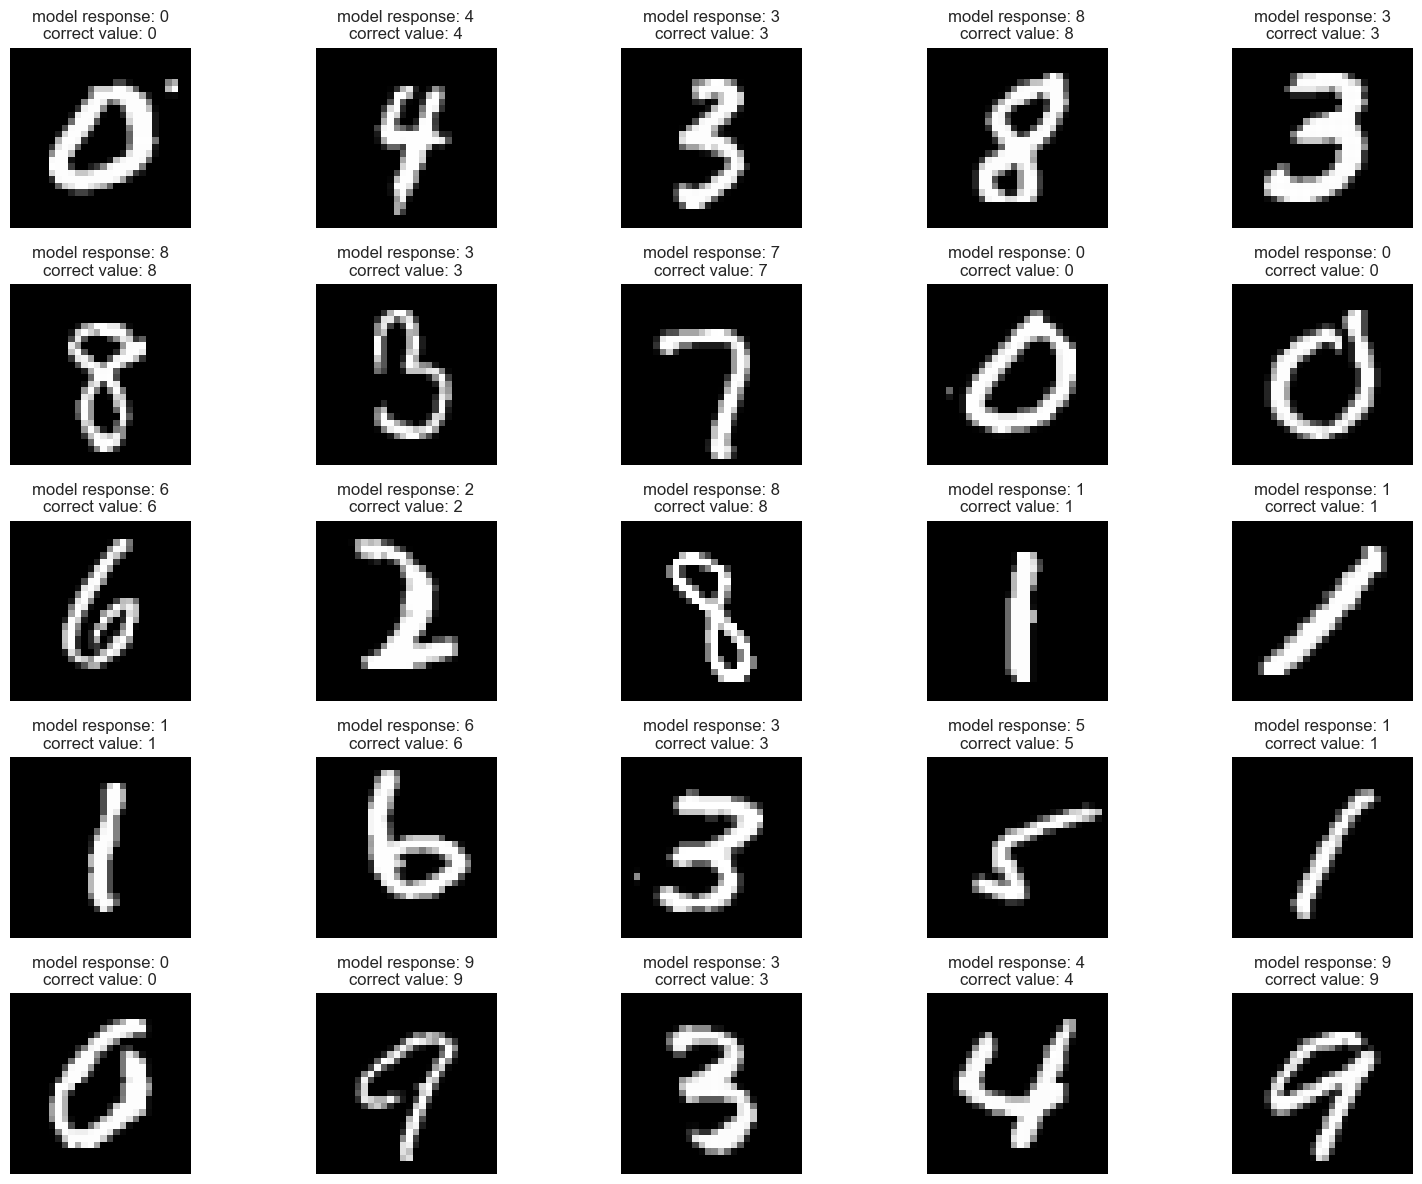

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 12))
examples_correct_responses = np.random.choice(correct_responses, 25, replace=False)
examples_wrong_responses = np.random.choice(wrong_responses, 25, replace=False)
for ax in axes.ravel():
    ax.imshow(test[0][examples_correct_responses[np.where(ax == axes.ravel())]].reshape((28, 28)), cmap="gray")
    ax.set_title(f"model response: {results[examples_correct_responses[np.where(ax == axes.ravel())]][0]}\n"
                 f"correct value: {test[1][examples_correct_responses[np.where(ax == axes.ravel())]][0]}")
    ax.grid(False)
    ax.axis('off')
fig.tight_layout()

In [9]:
len(correct_responses)

9332

## Examples of wrong recognized digits

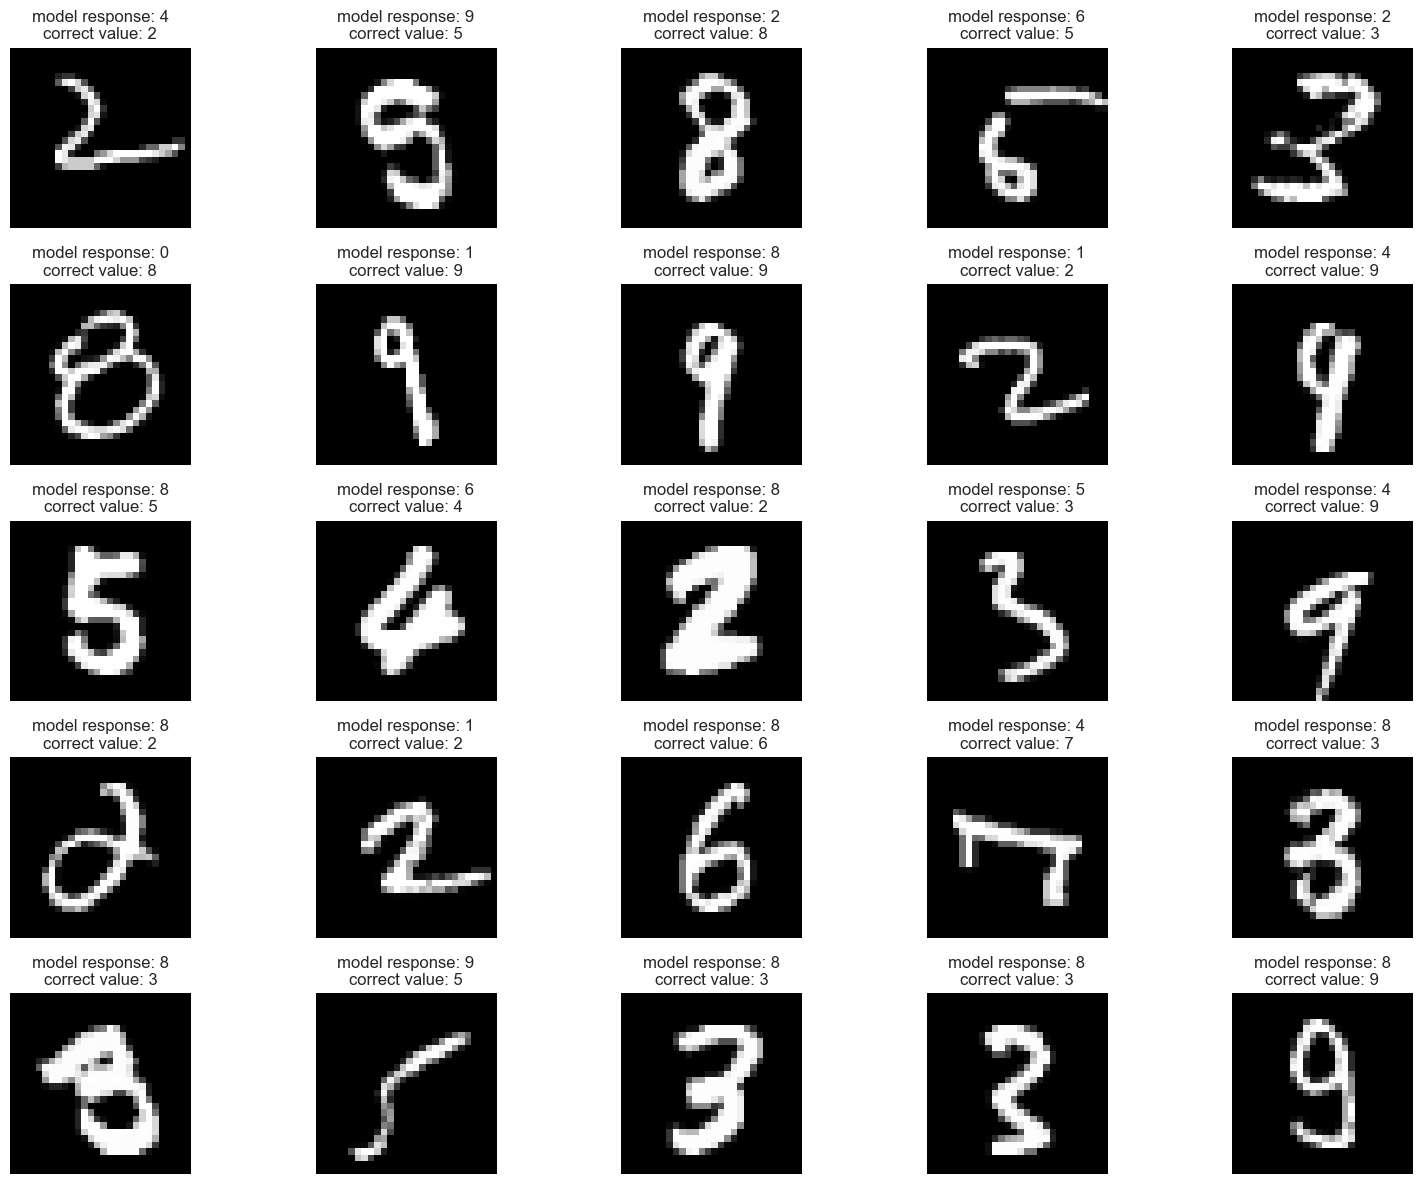

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 12))
for ax in axes.ravel():
    ax.imshow(test[0][examples_wrong_responses[np.where(ax == axes.ravel())]].reshape((28, 28)), cmap="gray")
    ax.set_title(f"model response: {results[examples_wrong_responses[np.where(ax == axes.ravel())]][0]}\n"
                 f"correct value: {test[1][examples_wrong_responses[np.where(ax == axes.ravel())]][0]}")
    ax.grid(False)
    ax.axis('off')
fig.tight_layout()

In [11]:
len(wrong_responses)

668

## Comparison of accuracy for ReLU and sigmoida, for batch and online learning and for complexity of network:
- Let us compare accuracy for the same parameters but different activation function:

In [12]:
train, validation, test = load_data()
epochs = 5
start = time.time()
nn1 = Neural_Network(train[0], [vectorized_result(i) for i in train[1]], [16, 10], 0.1, ReLU, d_ReLU, True, 0)
nn1.first_xy(0)
nn1.build_network()
nn1.run()
for i in range(epochs-1):
    nn1.shuffle()
    nn1.run()
time.time() - start

124.96410775184631

In [13]:
nn1.train_test_accuracy(test[0], test[1])

(0.29348, 0.2972)

- Now let's check what will happen when we set the learning rate to 0.01 and leave the activation function:

In [14]:
train, validation, test = load_data()
epochs = 5
start = time.time()
nn2 = Neural_Network(train[0], [vectorized_result(i) for i in train[1]], [16, 10], 0.01, ReLU, d_ReLU, True, 0)
nn2.first_xy(0)
nn2.build_network()
nn2.run()
for i in range(epochs-1):
    nn2.shuffle()
    nn2.run()
time.time() - start

147.7995936870575

In [15]:
nn2.train_test_accuracy(test[0], test[1])

(0.9495, 0.9374)

- Results are much better. Let's wee what will happen when we set the learning rate to 0.01 and activation function to sigmoida:

In [16]:
train, validation, test = load_data()
epochs = 5
start = time.time()
nn3 = Neural_Network(train[0], [vectorized_result(i) for i in train[1]], [16, 10], 0.01, sigmoida, d_sigmoida, True, 0)
nn3.first_xy(0)
nn3.build_network()
nn3.run()
for i in range(epochs-1):
    nn3.shuffle()
    nn3.run()
time.time() - start

126.39540386199951

In [17]:
nn3.train_test_accuracy(test[0], test[1])

(0.9518, 0.9468)

- Now let check the difference for online and batch learning for 5 epochs and batch learning which updates weights after 100 inputs:

In [18]:
train, validation, test = load_data()
epochs = 5
start = time.time()
nn4 = Neural_Network(train[0], [vectorized_result(i) for i in train[1]], [16, 10], 0.1, sigmoida, d_sigmoida, True, 100)
nn4.first_xy(0)
nn4.build_network()
nn4.run()
for i in range(epochs-1):
    nn4.shuffle()
    nn4.run()
time.time() - start

138.86241674423218

In [19]:
nn4.train_test_accuracy(test[0], test[1])

(0.90388, 0.9099)

- Let us build a more complex neural network (5 layers: 784, 128, 64, 16, 10 neurons in the layers, learning rate=0.1, sigmoida act function, online learning):

In [20]:
train, validation, test = load_data()
epochs = 5
start = time.time()
nn5 = Neural_Network(train[0], [vectorized_result(i) for i in train[1]], [128, 64, 16, 10], 0.1, sigmoida, d_sigmoida, True, 0)
nn5.first_xy(0)
nn5.build_network()
nn5.run()
for i in range(epochs-1):
    nn5.shuffle()
    nn5.run()
time.time() - start

317.6617844104767

In [21]:
nn5.train_test_accuracy(test[0], test[1])

(0.9801, 0.9683)

In [30]:
results = np.array([nn5.fit(i) for i in test[0]])
correct_answers = test[1]
correct_responses = np.where(results == correct_answers)[0]
wrong_responses = np.where(results != correct_answers)[0]

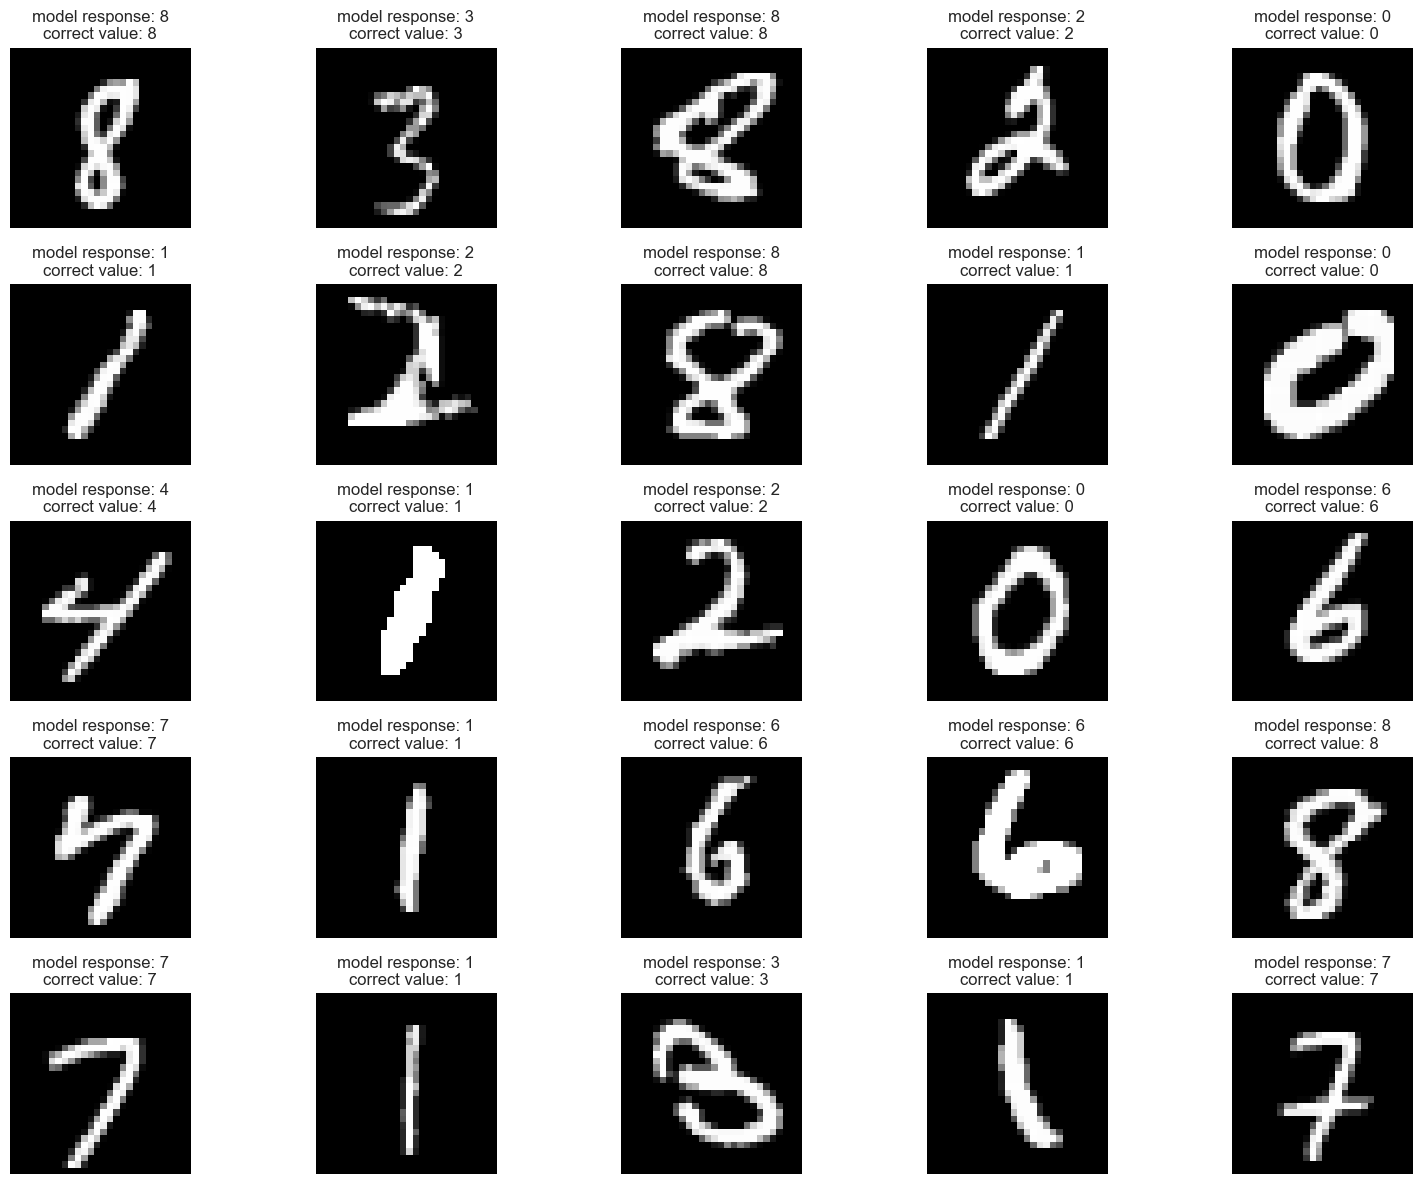

In [31]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 12))
examples_correct_responses = np.random.choice(correct_responses, 25, replace=False)
examples_wrong_responses = np.random.choice(wrong_responses, 25, replace=False)
for ax in axes.ravel():
    ax.imshow(test[0][examples_correct_responses[np.where(ax == axes.ravel())]].reshape((28, 28)), cmap="gray")
    ax.set_title(f"model response: {results[examples_correct_responses[np.where(ax == axes.ravel())]][0]}\n"
                 f"correct value: {test[1][examples_correct_responses[np.where(ax == axes.ravel())]][0]}")
    ax.grid(False)
    ax.axis('off')
fig.tight_layout()

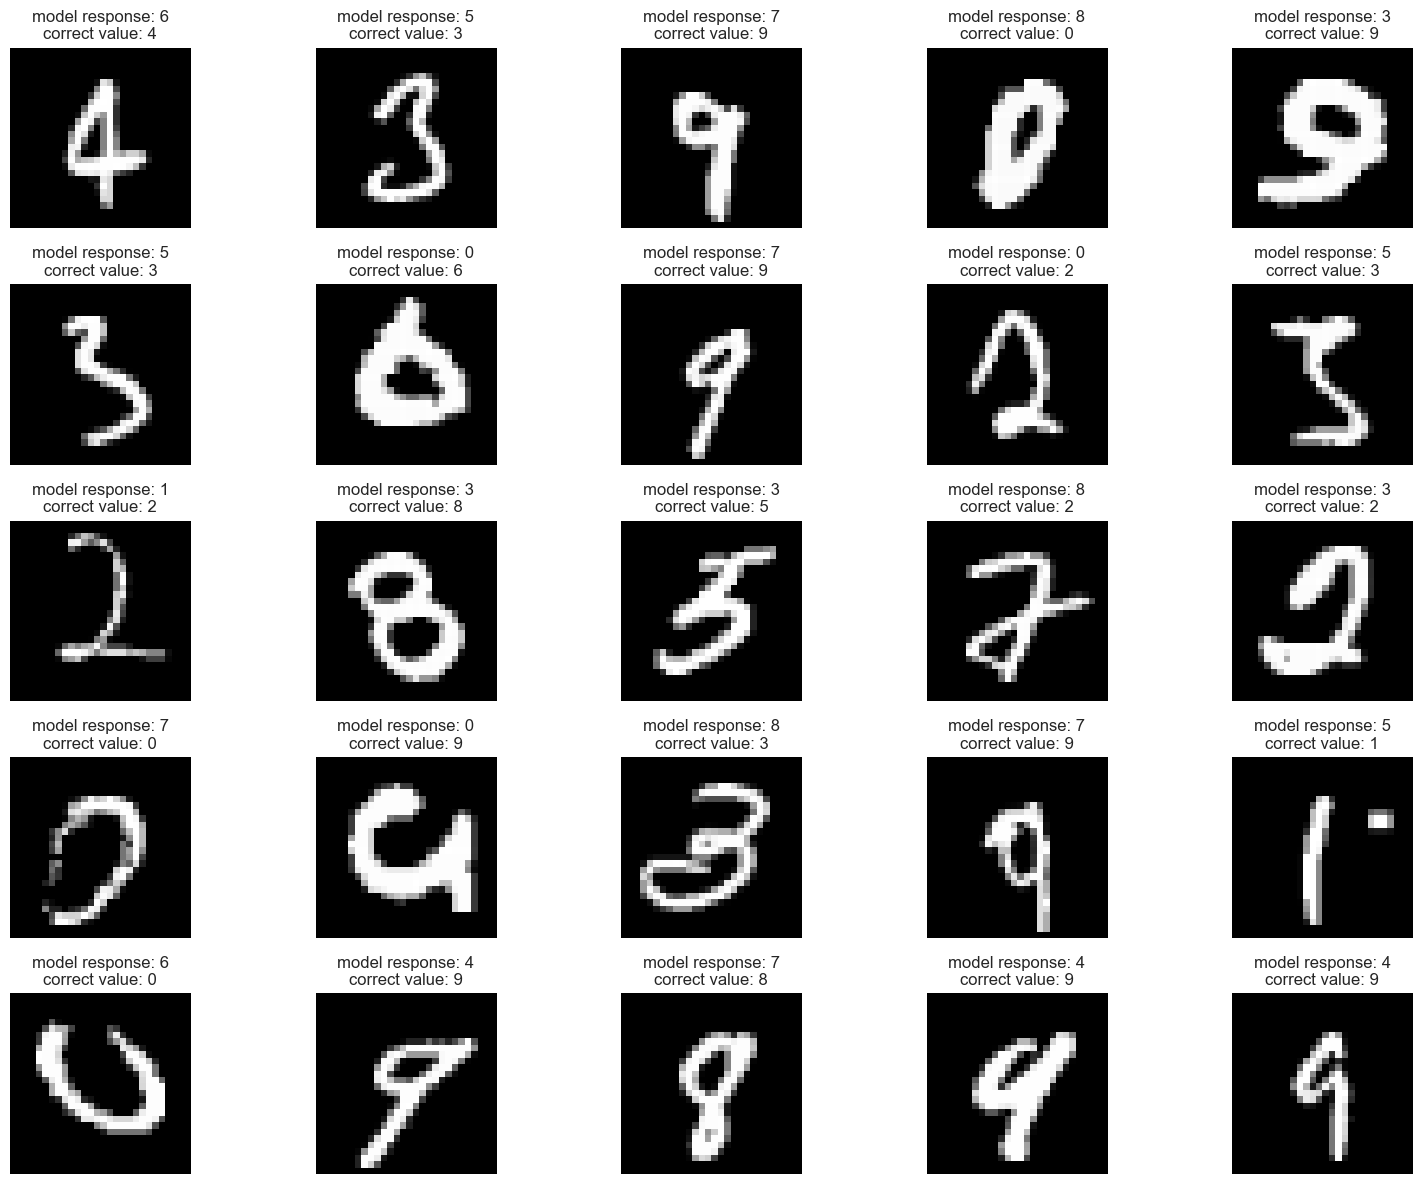

In [29]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 12))
for ax in axes.ravel():
    ax.imshow(test[0][examples_wrong_responses[np.where(ax == axes.ravel())]].reshape((28, 28)), cmap="gray")
    ax.set_title(f"model response: {results[examples_wrong_responses[np.where(ax == axes.ravel())]][0]}\n"
                 f"correct value: {test[1][examples_wrong_responses[np.where(ax == axes.ravel())]][0]}")
    ax.grid(False)
    ax.axis('off')
fig.tight_layout()